In [1]:
import numpy as np 
import random as rd
from functools import reduce
import itertools as itr
import scipy.linalg as sp
        
class vertex:
    def __init__(self, index, classicData):
        self.index=index
        self.classicData=classicData

In [2]:
densityKet0 = np.zeros([2,2],dtype=np.complex_)
densityKet0[0][0] = 1 

I=np.identity(2, dtype=np.complex_)

X = np.zeros([2,2],dtype=np.complex_)
X[0][1]=1
X[1][0]=1

H = np.ones([2,2],dtype=np.complex_)
H[1][1]*=-1
H=H/np.sqrt(2)

HX=np.matmul(H,X)

operators=[I, X, H, HX]

state0=np.zeros([2,2],dtype=np.complex_)
state0[0][0]=1

state1=np.zeros([2,2],dtype=np.complex_)
state1[1][1]=1

In [3]:
ket0=np.zeros([2,1],dtype=np.complex_)
ket0[0][0]=1
ket1=np.zeros([2,1],dtype=np.complex_)
ket1[1][0]=1
bra0=np.transpose(ket0)
bra1=np.transpose(ket1)

In [4]:
def partialTrace(rho, idx):
    # take density matrix (2^N) and an index of a node (qubit) idx, from 0 to N-1
    # give the reduced density matrix sigma (2*2) obrained doing a partial trace on the other qubits.

    power2toN=len(rho)
    N=int(np.log2(power2toN))
    formatOption='0'+str(N)+'b'

    x=[]
    y=[]

    # I could be faster by creating directly x and y 
    for i in range(2**N):
        binaryIndex=format(i,formatOption)

        if binaryIndex[idx]=='0':
            x.append(i)
        else:
            y.append(i)


    sigma=np.zeros([2,2],dtype=np.complex_)

    for p in zip(x,x):
        sigma[0][0]+=rho.item(p)

    for p in zip(x,y):
        sigma[0][1]+=rho.item(p)

    for p in zip(y,x):
        sigma[1][0]+=rho.item(p)

    for p in zip(y,y):
        sigma[1][1]+=rho.item(p)


    return sigma

In [5]:
def initQuantumDensity(classicConfiguration):
        #rho=0.5|0><0|+0.5|1><1|    
        initialQuantumState=0.5*np.identity(2, dtype=np.complex_)
        state=[]
        for classicData in classicConfiguration:
            state.append(operators[classicData]@initialQuantumState@np.conj(operators[classicData]))
            
        psi=reduce(np.kron, state)
        return psi

In [6]:
prob=[0.1, 0.2,0.55,0.15]

def initializeNodes(N, prob):
    
    Nodes = []
    assert sum(prob)==1
    
    for i in range(N):
        classicData=rd.choices(np.arange(4), prob)[0]
        Nodes.append(vertex(i,classicData))
        
    return Nodes

In [7]:
def initializeAdjacencyMatrix(N, density):
    
    maxEdges=N*(N-1)/2
    remainingEdges=round(density*maxEdges)
    edges={}

    while remainingEdges>0:

        a=rd.randint(0,N-1)
        b=rd.randint(0,N-1)

        while a==b:
            b=rd.randint(0,N-1)

        if (a,b) not in edges:
            edges[(a,b)]=1
            remainingEdges-=1
    
    return edges

In [8]:
class graph:
    
    
    def __init__(self, N, density, prob):
        self.Nodes=initializeNodes(N, prob)
        self.adjacencyMatrix=initializeAdjacencyMatrix(N, d)
        self.prob=prob
        self.quantumState=initQuantumDensity([n.classicData for n in self.Nodes])

    def classicState(self):
        state=[]
        for n in self.Nodes:
            state.append(n.classicData)
        return state

## Initilise graph with N vertex and d density

In [9]:
N=3
d=1
g = graph(N,d,prob)
graphClassicState=g.classicState()

In [10]:
g.adjacencyMatrix

{(2, 0): 1, (1, 2): 1, (2, 1): 1}

## Entropy computation

In [11]:
def probClassicalState(state, prob):
    
    l=[]
    for s in state:
        l.append(prob[s])
    
    return reduce(lambda a, b: a*b, l)

In [12]:
def entropy(graph):
    
    N=len(graph.Nodes)
    prob=graph.prob
    
    #S=0+0j

    S=0
    
    for classicConfiguration in itr.product(range(len(prob)),repeat=N):

        #calcola enrotropia
        rho=graph.quantumState

        S+=-probClassicalState(classicConfiguration, prob)*np.trace(np.matmul(rho,sp.logm(rho)))

    return np.real(S) # np.real(S) ? o np.abs(S) ?

In [13]:
s=entropy(g)

In [14]:
s

1.5707963267948954

*Attenzione! Rendere più efficiente?*

## Graph evolution

In [15]:
def classicRule(i, j):
    return np.int(np.floor(0.5*(i+j)))

In [16]:
def swapGate(edge,N):
    
    #CNOTup
    
    a=[]
    for i in range(N):
        if i==edge[0]:
            a.append(state0)
        else:
            a.append(I)
            
    A=reduce(np.kron, a)
    
    b=[]
    for i in range(N):
        if i==edge[0]:
            b.append(state1)
        elif i==edge[1]:
            b.append(X)
        else:
            b.append(I)

    B=reduce(np.kron, b)
    
    CNOTup=A+B
    
    #CNOTdown
    
    c=[]
    for i in range(N):
        if i==edge[1]:
            c.append(state0)
        else:
            c.append(I)
            
    C=reduce(np.kron, c)
    
    d=[]
    for i in range(N):
        if i==edge[1]:
            d.append(state1)
        elif i==edge[0]:
            d.append(X)
        else:
            d.append(I)

    D=reduce(np.kron, d)
    
    CNOTdown=C+D
       
    #swap    
    
    return CNOTup@CNOTdown@CNOTup

In [17]:
swapGate((0,1),6)

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]])

In [18]:
def evolution(graph):
    #ATTENZIONE, MODIFICA IL GRAFO ORIGINALE!
    # random selection of an edge
    edge=rd.choice(list(g.adjacencyMatrix.keys()))
    
    # classic evolution    
    c=classicRule(graph.Nodes[edge[0]].classicData, graph.Nodes[edge[1]].classicData)
    graph.Nodes[edge[0]].classicData=c
    graph.Nodes[edge[1]].classicData=c
    
    # application operator based on classic data
    state=[]
    for n in graph.Nodes:
        if n.index in edge:
            state.append(operators[n.classicData])
        else:
            state.append(I)
            
    O=reduce(np.kron, state)
    
    graph.quantumState=O@graph.quantumState@np.conj(O)
       
    #quantum evolution
    
    swap=swapGate(edge,len(graph.Nodes))
    
    graph.quantumState=0.5*(graph.quantumState+swap@graph.quantumState@np.conj(swap))
    
    #ATTENZIONE, MODIFICA IL GRAFO ORIGINALE!
    return graph

# Grafici

In [38]:
P = graph(6,0.7,prob)

In [39]:
entropy(P)

4.158883083359653

In [21]:
#ATTENZIONE il grafo viene modificato
evolution(P)
P.classicState()

[0, 2, 2, 2, 2]

In [22]:
gr=graph(5,0.9,prob)

entropyEvolution=[]



for i in range(20):
    entropyEvolution.append(entropy(gr))
    evolution(P)

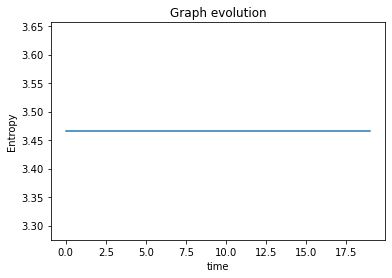

In [23]:
import matplotlib.pyplot as plt
  
# x axis values
x = range(len(entropyEvolution))
  
# plotting the points 
plt.plot(x, entropyEvolution)
  
# naming the x axis
plt.xlabel('time')
# naming the y axis
plt.ylabel('Entropy')
  
# giving a title to my graph
plt.title('Graph evolution')
  
# function to show the plot
plt.show()

In [65]:
evolution(P)

In [68]:
partialTrace(P.quantumState, 0)

array([[ 5.00000000e-01+0.j, -7.69008046e-18+0.j],
       [-7.69008046e-18+0.j,  5.00000000e-01+0.j]])

In [69]:
partialTrace(P.quantumState, 0)

array([[ 5.00000000e-01+0.j, -7.69008046e-18+0.j],
       [-7.69008046e-18+0.j,  5.00000000e-01+0.j]])

In [70]:
partialTrace(P.quantumState, 3)

array([[ 5.00000000e-01+0.j, -1.11855716e-17+0.j],
       [-1.11855716e-17+0.j,  5.00000000e-01+0.j]])

In [72]:
partialTrace(P.quantumState, 0)

array([[ 5.00000000e-01+0.j, -7.69008046e-18+0.j],
       [-7.69008046e-18+0.j,  5.00000000e-01+0.j]])

In [53]:
partialTrace(P.quantumState, 5)

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

In [81]:
rho=partialTrace(P.quantumState, 0)
S_0=-np.trace(np.matmul(rho,sp.logm(rho)))
S_0.real

0.6931471805599454